# Contents

1. Load data
    * 1.1. Helper functions for loading the data
    * 1.2. Generate dataset and export to .pkl files
    * 1.3. Visualise scans and annotations
    * 1.4. Class frequencies and weights
2. Cross-validation dataset [extension]
3. Data augmentation
    * 3.1. Helper methods for data augmentation
    * 3.2. Visualise data augmentations
4. Data pre-processing
    * 4.1. Histogram equalisation
        * 4.1.1. Helper methods for histogram equalisation
        * 4.1.2. Apply histogram equalisation to dataset
        * 4.1.3. Visualise histogram equalisation
    * 4.2. Input/output scaling and IOU evaluation
        * 4.2.1. Helper functions for input/output scaling and IOU evaluation
        * 4.2.2. Visualise scaled scans and annotations
5. 3D U-Net model
6. Model training
    * 6.1. Generate pre-processed augmented dataset
    * 6.2. Set model hyperparameters
    * 6.3. Helper functions for training
    * 6.4. Train model
7. Model inference
    * 7.1. Visualise predictions
        * 7.1.1. Example: 'best' prediction
        * 7.1.2. Example: 'worst' prediction

# Instructions

1. Install the relevant Python 3 dependencies specified in *requirements.txt*. 
> `pip3 install -r requirements.txt` 
2. Download and extract the dataset: __[*3D Prostate Structures*](http://url)__
3. To train the 3D U-Net model, execute cells in sections 1-6.
4. To test the trained 3D U-Net model, execute cells in section 7. 

*Note:* For interactive plot tool, Jupyter must be run locally (won't work if viewing via Github). 

As a starting point, I used the implementation from https://github.com/96imranahmed/3D-Unet. 
My major changes and additions are in sections 1.4, 3.1, 3.2, 4.1, 5, 6.3, 6.4 and 7. 

In [3]:
# Required modules
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import time
import os
import sys
import pydicom
import nrrd
import scipy.ndimage
import scipy.misc
import pickle
import random
import skimage
%matplotlib notebook

if sys.version_info[0] != 3:
    raise Exception("Python version 3 has to be used!")

print("Currently using")
print("\t numpy ", np.__version__)
print("\t scipy ", scipy.__version__)
print("\t matplotlib ", matplotlib.__version__)
print("\t tensorflow ", tf.__version__)
print("\t pydicom ", pydicom.__version__)
print("\t nrrd ", nrrd.__version__)
print("\t skimage ", skimage.__version__)

np.random.seed(37) # for reproducibility

Currently using
	 numpy  1.14.5
	 scipy  1.1.0
	 matplotlib  2.2.2
	 tensorflow  1.11.0
	 pydicom  1.1.0
	 nrrd  0.3.4
	 skimage  0.13.1


# 1. Load data

## 1.1. Helper functions for loading the data
* read MRI scans (.dcm) and annotations (.nddr)
* match scans with annotations 
* visualise 2D slices

In [47]:
def return_dcm(file_path, check_term = 'Prostate'):
    # Read all DCM (slices) files within a directory and order the files based on filename
    out_dcm = {}
    for dirName, subdirList, fileList in os.walk(file_path):
        c_dcm = []
        cur_name = ""
        dir_split = dirName.split("/")
        for f_chk in dir_split:
            if check_term in f_chk:
                cur_name = f_chk
        for filename in fileList:
            if ".dcm" in filename.lower():
                name = int(os.path.splitext(filename)[0])
                c_dcm.append((os.path.join(dirName,filename), name))
        if len(c_dcm) > 0:
            c_dcm = sorted(c_dcm, key = lambda t: t[1]) # Sort into correct order
            out_dcm[cur_name] = [c[0] for c in c_dcm]   # Store in dictionary
    return out_dcm

def return_nrrd(file_path):
    # Read all NRRD (annotation) files within a directory
    out_nrrd = {}
    for dirName, subdirList, fileList in os.walk(file_path):
        for filename in fileList:
            if ".nrrd" in filename.lower():
                name = filename.split('_')[0] 
                name = name.split('.')[0] # Get annotation name and store in dictionary
                out_nrrd[name] = os.path.join(dirName,filename)
    return out_nrrd

def get_dataset(data_dir, anns_dir):
    # Match DCM volumes with corresponding annotation files
    data_out = []
    shapes = {}
    d_dcm = return_dcm(data_dir)
    d_nrrd = return_nrrd(anns_dir)
    for i in d_nrrd:
        seg, opts = nrrd.read(d_nrrd[i])
        voxels = np.zeros(np.shape(seg))
        for j in range(len(d_dcm[i])):
            dicom_ref = pydicom.read_file(d_dcm[i][j])
            found = False
            chk_val = dicom_ref[("0020", "0013")].value 
            # Make sure you get the right slice! This is a bizarre specification thing related to DCM dataset
            # Note, if you just use the default filename ordering you get mismatched slices!
            if int(chk_val.__str__()) - 1 < np.shape(voxels)[-1]:
                voxels[:, :, int(chk_val.__str__()) - 1] = dicom_ref.pixel_array
            else: 
                print('Index: ',str(int(chk_val.__str__()) - 1), ' too large for ', i, ' skipping!')
        # Rotate and flip annotations to match volumes
        seg = scipy.ndimage.interpolation.rotate(seg, 90, reshape = False)
        for i in range(np.shape(seg)[2]):
            cur_img = np.squeeze(seg[:, :, i])
            seg[:, :, i] = np.flipud(cur_img)
        # Store volume shapes (for debug)
        if voxels.shape in shapes:
            shapes[voxels.shape] += 1
        else:
            shapes[voxels.shape] = 1
        # Saves data
        data_out.append((voxels, seg))
    return data_out

def plot_slice(slice_in, is_anns = False, num_anns = 4):
    # Plot a slice of data - can either be raw image data or corresponding annotation
    slice_in = np.squeeze(slice_in)
    plt.figure()
    plt.set_cmap(plt.bone())
    if is_anns:
        plt.pcolormesh(slice_in, vmin = 0, vmax = num_anns - 1)
    else:
        plt.pcolormesh(slice_in)
    plt.show()

##########################################################################
# Multi-slice view code extracted and adapted from: 
# https://www.datacamp.com/community/tutorials/matplotlib-3d-volumetric-data

def multi_slice_viewer(feats, anns = None, preds = None, num_classes = 4, no_axis=False):
    # Plot feats, anns, predictions in multi-slice-view
    # feats OR feats + anns OR feats + anns + preds
    if anns is None:
        fig, ax = plt.subplots()
        ax.volume = feats
        ax.index = feats.shape[-1] // 2
        ax.imshow(feats[:, :, ax.index],  cmap='bone')
        fig.canvas.mpl_connect('key_press_event', process_key)
    else:
        if preds is None:
            fig, axarr = plt.subplots(1, 2)
            plt.tight_layout()
            axarr[0].volume = feats
            axarr[0].index = 0
            axarr[0].imshow(feats[:, :, axarr[0].index],  cmap='bone')
            axarr[0].set_title('Scans')
            axarr[1].volume = anns
            axarr[1].index = 0
            axarr[1].imshow(anns[:, :, axarr[1].index],  cmap='bone', vmin = 0, vmax = num_classes)
            axarr[1].set_title('Annotations')
            fig.canvas.mpl_connect('key_press_event', process_key)
        else:
            fig, axarr = plt.subplots(1, 3)
            plt.tight_layout()
            axarr[0].volume = feats
            axarr[0].index = 0
            axarr[0].imshow(feats[:, :, axarr[0].index],  cmap='bone')
            axarr[0].set_title('Scans')
            axarr[1].volume = anns
            axarr[1].index = 0
            axarr[1].imshow(anns[:, :, axarr[1].index],  cmap='bone', vmin = 0, vmax = num_classes)
            axarr[1].set_title('Annotations')
            axarr[2].volume = preds
            axarr[2].index = 0
            axarr[2].imshow(preds[:, :, axarr[2].index],  cmap='bone', vmin = 0, vmax = num_classes)
            axarr[2].set_title('Predictions')
            fig.canvas.mpl_connect('key_press_event', process_key)
        if no_axis:
            for a in axarr:
                a.set_axis_off()
            
def process_key(event):
    # Process key_press events
    fig = event.canvas.figure
    if event.key == 'j':
        for ax in fig.axes: 
            previous_slice(ax)
    elif event.key == 'k':
        for ax in fig.axes: 
            next_slice(ax)            
    fig.canvas.draw()

def previous_slice(ax):
    # Go to the previous slice
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[-1]  # wrap around using %
    ax.images[0].set_array(volume[:, :, ax.index])

def next_slice(ax):
    # Go to the next slice
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[-1]
    ax.images[0].set_array(volume[:, :, ax.index])

## 1.2. Generate dataset and export to .pkl files

Generates dataset from specified folders and saves it to pickle files. <br>
Leaderboard dataset is used as a validation set (in order to compare later design decisions and to decide when to stop training). <br>
*Note:* This step does not need to be performed again. 

#### Important:
Change the below paths to data folders, if necessary. 

In [18]:
# .dcm data files
data_train_dir = './../data/train/'              
data_leader_dir = './../data/leaderboard/' 
data_test_dir = './../data/test/'

# .nrrd annotation files
anns_train_dir = './../data/train-segm/'         
anns_leader_dir = './../data/leaderboard-segm/'   
anns_test_dir = './../data/test-segm/'          

train = get_dataset(data_train_dir, anns_train_dir)
valid = get_dataset(data_leader_dir, anns_leader_dir)
test = get_dataset(data_test_dir, anns_test_dir)

if not os.path.exists('./pickles'):
    os.makedirs('./pickles')
pickle.dump(file = open('./pickles/train.pkl', 'wb'), obj = train)
pickle.dump(file = open('./pickles/valid.pkl', 'wb'), obj = valid)
pickle.dump(file = open('./pickles/test.pkl', 'wb'), obj = test)

print("\nTraining scans:", len(train), "\t\t Scan slices:", np.sum([x.shape[2] for x,_ in train]), 
      "\nValidation scans:", len(valid), "\t\t Scan slices:", np.sum([x.shape[2] for x,_ in valid]), 
      "\nTesting scans: ", len(test), "\t\t Scan slices:", np.sum([x.shape[2] for x,_ in test]))
print("Sample 3D scans' shapes:", train[2][0].shape, valid[1][0].shape, test[9][0].shape) # as we can see these shapes vary


Training scans: 60 		 Scan slices: 1544 
Validation scans: 10 		 Scan slices: 261 
Testing scans:  10 		 Scan slices: 271
Sample 3D scans' shapes: (320, 320, 20) (384, 384, 19) (400, 400, 34)


## 1.3. Visualise scans and annotations

We can verify that the loaded scans and annotations match for a sample dataset example. This indicates that the features and labels are correctly formatted. 

Annotation labels: 
* 0: background - black 
* 1: peripheral zone (PZ) - dark gray 
* 2: central gland (CG) - bright gray 

**Press 'j' or 'k' to cycle through the plots in depth (Jupyter must be run locally!).**

<IPython.core.display.Javascript object>


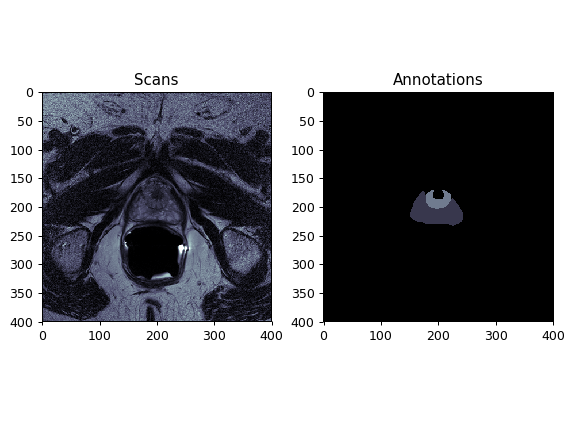

In [11]:
img_id = 12
multi_slice_viewer(train[img_id][0], train[img_id][1])

## 1.4. Class frequencies and weights
Class weights (inversely proportional to class frequencies) will be used in the weighted cross-entropy loss function to handle class imbalance. 

In [11]:
from collections import Counter
class_freq = {0:0, 1:0, 2:0}
for i in range(len(train)):
    for j in range(train[i][1].shape[2]):
        d = Counter(train[i][1][:,:,j].flatten())
        class_freq[0] += d[0]
        class_freq[1] += d[1]
        class_freq[2] += d[2]
print("Class frequencies in training set: ", class_freq)

inv_class_freq = 1. / np.array([class_freq[0], class_freq[1], class_freq[2]], dtype=np.float64)
class_weights = inv_class_freq / sum(inv_class_freq)
print("Class weights (inversely proportional to class frequencies): ", class_weights)

Class frequencies in training set:  {0: 209647654, 1: 1350276, 2: 2937686}
Class weights (inversely proportional to class frequencies):  [0.00439314 0.68209101 0.31351585]


# 2. Cross-validation split [extension]

Perform k-fold cross validation, as suggested in the 3D U-Net paper. 
For each fold, this needs to be run again. 

*Note:* **This is left as an extension and it was not performed as it would be very time-consuming. **

In [3]:
do_cross_val = False # Whether to do cross-validation
if do_cross_val:
    data_total = train + valid + test
    K_FOLD = 3
    VALID_FRAC = 0.25 # fraction of the training set used as validation set
    CURRENT_FOLD = 0  # need to be set to: 0, 1, ... K_FOLD-1

    val_split = len(data_total)/K_FOLD
    val_idx = CURRENT_FOLD*val_split
    train = data_total[:val_idx] + data_total[val_idx+val_split:]
    valid = train[:int(len(train)*VALID_FRAC)]
    train = train[int(len(train)*VALID_FRAC):]
    test = data_total[val_idx:val_idx+val_split]
    data_total = []

# 3. Data augmentation

As suggested in the paper, the training dataset is **randomly** augmented with minor: 
* rotations, 
* scales and crops,
* gray value augmentations, 
* and elastic distortions (smooth dense deformation field). 


Data augmentation is performed in the pre-processing stage (as opposed to the augmentation on-the-fly). This implies:
* faster training 
* higher memory requirements (this is probably the reason why the paper chose the augmentation on-the-fly)

## 3.1. Helper methods for data augmentation

In [5]:
def rotate(voxels, lbls, theta = None):
    # Rotate volume by a minor angle (+/- 10 degrees: determined by investigation of dataset variability)
    if theta is None:
        theta = random.randint(-10, 10)
    vox_new = scipy.ndimage.interpolation.rotate(voxels, theta, reshape = False)
    lbl_new = scipy.ndimage.interpolation.rotate(lbls, theta, reshape = False)
    return vox_new, lbl_new

def scale_and_crop(voxels, lbls):
    # Scale the volume by a minor size and crop around centre (can also modify for random crop)
    o_s = voxels.shape
    r_s = [0]*len(o_s)
    scale_factor = random.uniform(1, 1.2)
    vox_zoom = scipy.ndimage.interpolation.zoom(voxels, scale_factor, order=1)
    lbl_zoom = scipy.ndimage.interpolation.zoom(lbls, scale_factor, order=0)
    new_shape = vox_zoom.shape
    # Start with offset
    for i in range(len(o_s)):
        if new_shape[i] == 1: 
            r_s[i] = 0
            continue
        r_c = int(((new_shape[i] - o_s[i]) - 1)/2)
        r_s[i] = r_c
    r_e = [r_s[i] + o_s[i] for i in list(range(len(o_s)))]
    vox_zoom = vox_zoom[r_s[0]:r_e[0], r_s[1]:r_e[1], r_s[2]:r_e[2]]
    lbl_zoom = lbl_zoom[r_s[0]:r_e[0], r_s[1]:r_e[1], r_s[2]:r_e[2]]
    return vox_zoom, lbl_zoom

def grayscale_variation(voxels, lbls):
    # Introduce a random global increment in gray-level value of volume. 
    im_min = np.min(voxels)
    im_max = np.max(voxels)
    mean = np.random.normal(0, 0.1)
    smp = np.random.normal(mean, 0.01, size = np.shape(voxels))
    voxels = voxels + im_max*smp
    voxels[voxels <= im_min] = im_min # Clamp to min value
    voxels[voxels > im_max] = im_max  # Clamp to max value
    return voxels, lbls

from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_deformation(voxels, lbls, alpha=None, sigma=None, mode="constant", cval=0, is_random=False): 
    # Apply elastic deformation/distortion to the wolume
    # Adapted from: https://tensorlayer.readthedocs.io/en/stable/_modules/tensorlayer/prepro.html#elastic_transform
    if alpha == None:
        alpha=voxels.shape[1]*3.
    if sigma == None:
        sigma=voxels.shape[1]*0.07
    if is_random is False:
        random_state = np.random.RandomState(None)
    else:
        random_state = np.random.RandomState(int(time.time()))
        
    if len(voxels.shape) == 3:
        voxels = np.reshape(voxels, (voxels.shape[0], voxels.shape[1], voxels.shape[2], 1) )
        lbls = np.reshape(lbls, (lbls.shape[0], lbls.shape[1], lbls.shape[2], 1) )
        
    shape = (voxels.shape[0], voxels.shape[1])
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode=mode, cval=cval) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode=mode, cval=cval) * alpha
    x_, y_ = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x_ + dx, (-1, 1)), np.reshape(y_ + dy, (-1, 1))
    
    new_voxels = np.zeros(voxels.shape)
    new_lbls = np.zeros(lbls.shape)
    for i in range(voxels.shape[2]): # apply the same distortion to each slice within the volume
        new_voxels[:,:,i,0] = map_coordinates(voxels[:,:,i,0], indices, order=1).reshape(shape)
        new_lbls[:,:,i,0] = map_coordinates(lbls[:,:,i,0], indices, order=1).reshape(shape)
        
    return new_voxels, new_lbls

def sample_with_p(p):
    # Helper function to return boolean of a sample with given probability p
    if random.random() < p:
        return True
    else:
        return False

def get_random_perturbation(voxels, lbls):
    # Generate a random perturbation of the input feature + label
    p_rotate = 0.6
    p_scale = 0.6
    p_gray = 0.6
    p_deform = 0.6
    new_voxels, new_lbls = voxels, lbls
    if sample_with_p(p_rotate):
        new_voxels, new_lbls = rotate(new_voxels, new_lbls)
    if sample_with_p(p_scale):
        new_voxels, new_lbls = scale_and_crop(new_voxels, new_lbls)
    if sample_with_p(p_gray):
        new_voxels, new_lbls = grayscale_variation(new_voxels, new_lbls)
    if sample_with_p(p_deform):
        new_voxels, new_lbls = elastic_deformation(new_voxels, new_lbls)
    return new_voxels, new_lbls

def plot_augmentation(img_org, ann_org, img_aug, ann_aug, title_aug='Augmented', axis_off=True):
    # Plot original and augmented image along with its annotation
    # Works for different kinds of augmentations
    if len(ann_org) == 0:
        n = 1 # Annotations are not plotted
    else:
        n = 2 # Annotations are plotted
    plt.figure(figsize=(5,5))
    plt.subplot(n,2,1)
    if axis_off:
        plt.axis('off')
    plt.title("Original scan")
    plt.imshow(img_org, cmap=plt.cm.gray)
    plt.subplot(n,2,2)
    if axis_off:
        plt.axis('off')
    plt.title(title_aug)
    plt.imshow(img_aug, cmap=plt.cm.gray)
    if n > 1:
        plt.subplot(n,2,3)
        if axis_off:
            plt.axis('off')
        plt.title("Original annotation")
        plt.imshow(ann_org, cmap=plt.cm.gray)
        plt.subplot(n,2,4)
        if axis_off:
            plt.axis('off')
        plt.title(title_aug)
        plt.imshow(ann_aug, cmap=plt.cm.gray)
    plt.tight_layout()
    plt.show()

## 3.2. Visualise data augmentations

<IPython.core.display.Javascript object>


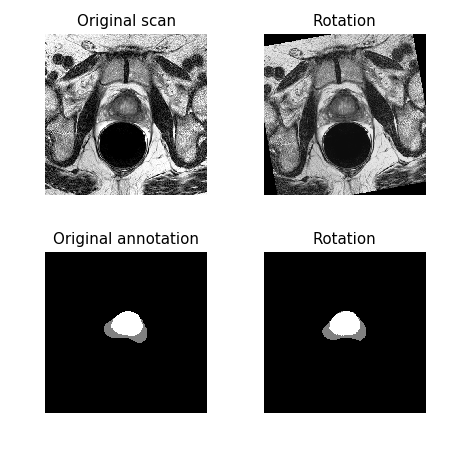

<IPython.core.display.Javascript object>


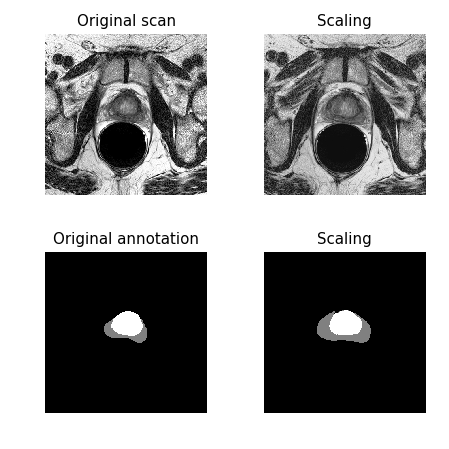

<IPython.core.display.Javascript object>


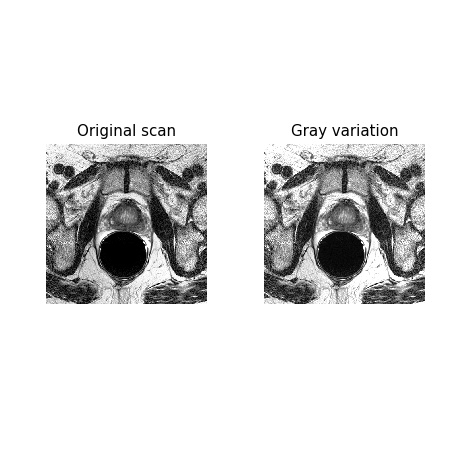

<IPython.core.display.Javascript object>


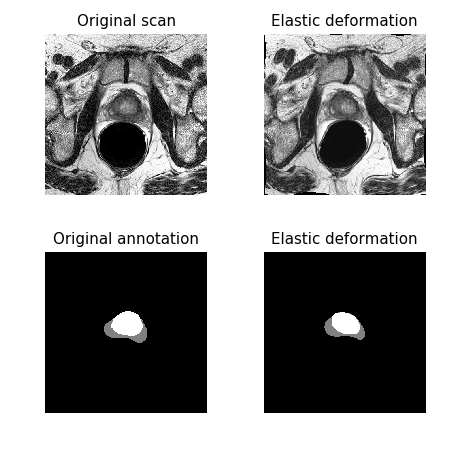

In [9]:
# Load the dataset if needed
# train = pickle.load(file = open('./pickles/train.pkl', 'rb'))

img_id = 12
slice_id = 8

imgs_org = train[img_id][0]
anns_org = train[img_id][1]

img_org = train[img_id][0][:,:,slice_id]
ann_org = train[img_id][1][:,:,slice_id]

# Rotation
imgs_aug, anns_aug = rotate(imgs_org, anns_org, theta=10)
plot_augmentation(img_org, ann_org, imgs_aug[:,:,slice_id], anns_aug[:,:,slice_id], title_aug='Rotation')

# Scaling
imgs_aug, anns_aug = scale_and_crop(imgs_org, anns_org)
plot_augmentation(img_org, ann_org, imgs_aug[:,:,slice_id], anns_aug[:,:,slice_id], title_aug='Scaling')

# Gray value variation
imgs_aug, anns_aug = grayscale_variation(imgs_org, anns_org)
plot_augmentation(img_org, [], imgs_aug[:,:,slice_id], [], title_aug='Gray variation')

# Elastic deformation (smooth dense deformation field)
imgs_aug, anns_aug = elastic_deformation(imgs_org, anns_org)
plot_augmentation(img_org, ann_org, imgs_aug[:,:,slice_id,0], anns_aug[:,:,slice_id,0], title_aug='Elastic deformation')

# 4. Data pre-processing

## 4.1. Histogram equalisation

Histogram equalisation (HE) is a technique used to enhance low-contrast images, by spreading out the most frequent intenshity values. The resulting equalised image has a roughly linear cumulative distribution function. 

HE is applied to all three paritions: train, valid and test. It further ensures that the image intensity values are within the $\left[0,1\right]$ range. 

### 4.1.1. Helper methods for histogram equalisation

In [6]:
from skimage import exposure, img_as_float

def hist_equalise(dataset):
    # Perform histogram equalisation on each scan slice 
    for i in range(len(dataset)): # Over subjects
        for j in range(dataset[i][0].shape[2]): # Over scan slices
            dataset[i][0][:,:,j] = exposure.equalize_hist(dataset[i][0][:,:,j])
            
def plot_img_and_hist(image, axes, bins=100):
    # Plot an image along with its histogram and cumulative histogram.
    # Code adapted from: http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()
    
    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()
    
    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

def plot_histogram_equalisation(img_org, img_heq):
    # Plot original low contrast image and histogram eualised image, with their histograms and cumulative histograms.
    # Code adapted from: http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html

    fig = plt.figure(figsize=(7, 7))
    axes = np.zeros((2, 2), dtype=np.object)
    axes[0, 0] = fig.add_subplot(2, 2, 1)
    for i in range(1, 2):
        axes[0, i] = fig.add_subplot(2, 2, 1+i, sharex=axes[0,0], sharey=axes[0,0])
    for i in range(0, 2):
        axes[1, i] = fig.add_subplot(2, 2, 3+i)

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_org, axes[:, 0])
    ax_img.set_title('Original low contrast image')

    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_ylabel('Number of pixels')
    ax_hist.set_yticks(np.linspace(0, y_max, 5))

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_heq, axes[:, 1])
    ax_img.set_title('Histogram equalised image')

    ax_cdf.set_ylabel('Fraction of total intensity', color='red')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

    fig.tight_layout(h_pad=-1.5)
    plt.show()

### 4.1.2. Apply histogram equalisation to dataset

*Note:* This step does not need to be performed again. 

In [7]:
# Load the non-histogram equalised dataset if needed
train = pickle.load(file = open('./pickles/train.pkl', 'rb'))
valid = pickle.load(file = open('./pickles/valid.pkl', 'rb'))
test = pickle.load(file = open('./pickles/test.pkl', 'rb'))

hist_equalise(train) # in-place
hist_equalise(valid)
hist_equalise(test)

# Save histogram equalised dataset
pickle.dump(file = open('./pickles/heq_train.pkl', 'wb'), obj = train)
pickle.dump(file = open('./pickles/heq_valid.pkl', 'wb'), obj = valid)
pickle.dump(file = open('./pickles/heq_test.pkl', 'wb'), obj = test)

### 4.1.3 Visualise histogram equalisation

<IPython.core.display.Javascript object>


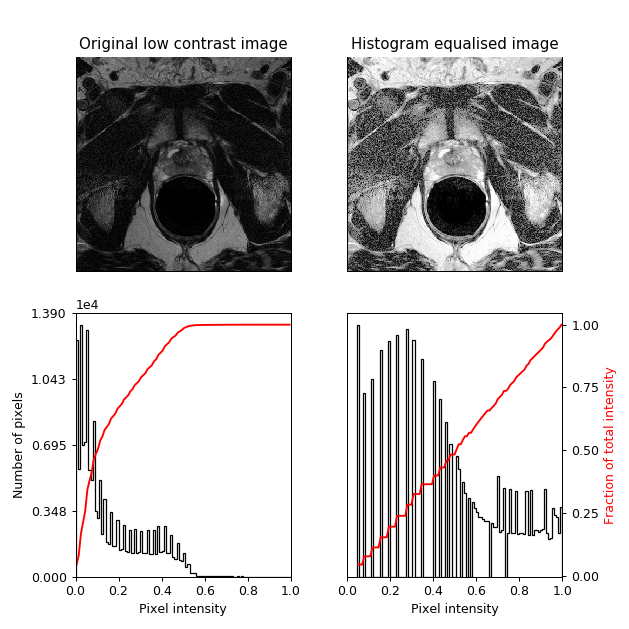

In [5]:
# Load the non-histogram equalised dataset as needed
# nhe_train = pickle.load(file = open('./pickles/train.pkl', 'rb'))
# nhe_valid = pickle.load(file = open('./pickles/valid.pkl', 'rb'))
nhe_test = pickle.load(file = open('./pickles/test.pkl', 'rb'))
# Load the histogram equalised dataset as needed
# train = pickle.load(file = open('./pickles/heq_train.pkl', 'rb'))
# valid = pickle.load(file = open('./pickles/heq_valid.pkl', 'rb'))
test = pickle.load(file = open('./pickles/heq_test.pkl', 'rb'))

# Show HE on a sample image
img_id = 9
slice_id = 10
img = nhe_test[img_id][0][:,:,slice_id]
img = img / np.max(img) # Scale to 0-1 range
img_eq = test[img_id][0][:,:,slice_id] # Already scaled to 0-1 range
plot_histogram_equalisation(img, img_eq)

# 4.2. Input/output scaling and IOU evaluation

## 4.2.1. Helper functions for input/output scaling and IOU evaluation
* input/output scaling: generate volume and label tensors that can be passed into the Tensorflow format and in the default `channel_last` ordering expected by Tensorflow
* calculate Mean IOU (with respect to original unscaled labels)

In [7]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import os
import sys
import pydicom
import nrrd
import scipy.ndimage
import random
import pickle
%matplotlib notebook

INPUT_SIZE = 120 # Input feature width/height
OUTPUT_SIZE = 120 # Output feature width/height (as defined by model)
INPUT_DEPTH = 12 # Input depth 
OFF_IMAGE_FILL = 0 # What to fill an image with if padding is required to make Tensor
OFF_LABEL_FILL = 0 # What to fill a label with if padding is required to make Tensor
OUTPUT_CLASSES = 3 # Number of output classes in dataset: the fourth class can be used for unlabelled datapoints (not needed for this dataset)

# Get 'natural' OUTPUT_DEPTH according to scipy method
io_zoom = OUTPUT_SIZE/INPUT_SIZE
zero_chk = np.zeros((INPUT_SIZE, INPUT_SIZE, INPUT_DEPTH))
OUTPUT_DEPTH = np.shape(scipy.ndimage.interpolation.zoom(zero_chk, io_zoom, order = 1))[-1]
# Alternatively, this can be forced to match expected tensorflow output (note, extra padding is applied if depth mismatch)
OUTPUT_DEPTH = 12 

def get_scaled_input(data, min_i = INPUT_SIZE, min_o = OUTPUT_SIZE, depth = INPUT_DEPTH, 
                    depth_out = OUTPUT_DEPTH, image_fill = OFF_IMAGE_FILL, 
                    label_fill = OFF_LABEL_FILL, n_classes = OUTPUT_CLASSES, norm_max = 500):
    
    # Takes raw data (x, y) and scales to match desired input and output sizes to feed into Tensorflow
    # Pads and normalises input and also moves axes around to orientation expected by tensorflow
    
    input_scale_factor = min_i/data[0].shape[0]
    output_scale_factor = min_o/data[0].shape[0]

    vox_zoom = None
    lbl_zoom = None

    if not input_scale_factor == 1:
        vox_zoom = scipy.ndimage.interpolation.zoom(data[0], input_scale_factor, order = 1) 
        # Order 1 is bilinear - fast and good enough
    else:
        vox_zoom = data[0]

    if not output_scale_factor == 1:
        lbl_zoom = scipy.ndimage.interpolation.zoom(data[1], output_scale_factor, order = 0) 
        # Order 0 is nearest neighbours: VERY IMPORTANT as it ensures labels are scaled properly (and stay discrete)
    else:
        lbl_zoom = data[1]   

    lbl_pad = label_fill*np.ones((min_o, min_o, depth_out - lbl_zoom.shape[-1]))
    lbl_zoom = np.concatenate((lbl_zoom, lbl_pad), 2)
    lbl_zoom = lbl_zoom[np.newaxis, :, :, :]
    
    vox_pad = image_fill*np.ones((min_i, min_i, depth - vox_zoom.shape[-1]))
    vox_zoom = np.concatenate((vox_zoom, vox_pad), 2)
    
    max_val = np.max(vox_zoom)
    if not np.max(vox_zoom) == 0:
        vox_zoom = vox_zoom * norm_max/np.max(vox_zoom)
        
    vox_zoom = vox_zoom[np.newaxis, :, :, :]

    vox_zoom = np.swapaxes(vox_zoom, 0, -1)
    lbl_zoom = np.swapaxes(lbl_zoom, 0, -1)
    # Swap axes
        
    return vox_zoom, lbl_zoom

def upscale_segmentation(lbl, shape_desired):
    # Returns scaled up label for a given input label and desired shape. Required for Mean IOU calculation
    
    scale_factor = shape_desired[0]/lbl.shape[0]
    lbl_upscale = scipy.ndimage.interpolation.zoom(lbl, scale_factor, order = 0)
    # Order 0 EVEN more important here
    lbl_upscale = lbl_upscale[:, :, :shape_desired[-1]]
    if lbl_upscale.shape[-1] < shape_desired[-1]:
        pad_zero = OFF_LABEL_FILL*np.zeros((shape_desired[0], shape_desired[1], shape_desired[2] - lbl_upscale.shape[-1]))
        lbl_upscale = np.concatenate((lbl_upscale, pad_zero), axis = -1)
    return lbl_upscale

def get_label_accuracy(pred, lbl_original):
    # Get pixel-wise labelling accuracy (DEMO metric)
    
    # Swap axes back
    pred = swap_axes(pred)
    pred_upscale = upscale_segmentation(pred, np.shape(lbl_original))
    return 100*np.sum(np.equal(pred_upscale, lbl_original))/np.prod(lbl_original.shape)

def get_mean_iou(pred, lbl_original, num_classes = OUTPUT_CLASSES, ret_full = False, reswap = False):
    # Get mean IOU between input predictions and target labels. Note, method implicitly resizes as needed
    # Ret_full - returns the full iou across all classes
    # Reswap - if lbl_original is in tensorflow format, swap it back into the format expected by plotting tools (+ format of raw data)
    
    # Swap axes back 
    pred = swap_axes(pred)
    if reswap:
        lbl_original = swap_axes(lbl_original)
    pred_upscale = upscale_segmentation(pred, np.shape(lbl_original))
    iou = [1]*num_classes
    for i in range(num_classes): 
        test_shape = np.zeros(np.shape(lbl_original))
        test_shape[pred_upscale == i] = 1
        test_shape[lbl_original == i] = 1
        full_sum = int(np.sum(test_shape))
        test_shape = -1*np.ones(np.shape(lbl_original))
        test_shape[lbl_original == i] = pred_upscale[lbl_original == i]
        t_p = int(np.sum(test_shape == i))
        if not full_sum == 0:
            iou[i] = t_p/full_sum
    if ret_full:
        return iou
    else: 
        return np.mean(iou)
    
def swap_axes(pred):
    # Swap those axes
    pred = np.swapaxes(pred, -1, 0)
    pred = np.squeeze(pred)
    return pred

## 4.2.2. Visualise scaled scans and annotations

*Note:* Run section 1.1 if it has not been executed yet. 

**Press 'j' or 'k' to cycle through the plots in depth (Jupyter must be run locally!).**

<IPython.core.display.Javascript object>


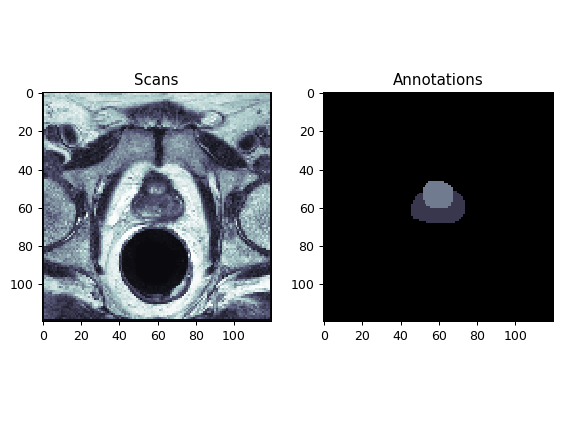

Mean IOU with itself
[1.0, 1.0, 1.0, 1]
Mean IOU with original labels
[0.9978630961901396, 0.695839437445063, 0.7089287155889239, 1]


In [19]:
img_id = 15 # Image ID to view
dataset = train
x, y = get_scaled_input(dataset[img_id]) # Shows that this works - can check x,y shapes if needed
x_swap = swap_axes(x)
y_upscale = upscale_segmentation(swap_axes(y), np.shape(swap_axes(x)))
multi_slice_viewer(x_swap, y_upscale)  # View scaled images and labels together 

# Compute mean iou with itself & upsampled data
x, y = get_scaled_input(dataset[img_id])
print('Mean IOU with itself')
print(get_mean_iou(y, y, ret_full = True, reswap = True))
print('Mean IOU with original labels')
print(get_mean_iou(y, dataset[img_id][1], ret_full = True, reswap = False))

# 5. 3D U-Net model

Set `simpleUNet` to choose if the Simplified 3D U-Net model (with one horizontal level removed) is used. This was inspired by https://github.com/mirzaevinom/prostate_segmentation. 

In [8]:
simpleUNet = False

class UNetwork():
    
    def conv_batch_relu(self, tensor, filters, kernel = [3,3,3], stride = [1,1,1], is_training = True):
        # Produces the conv_batch_relu combination as in the paper
        padding = 'valid'
        if self.should_pad: padding = 'same'
    
        conv = tf.layers.conv3d(tensor, filters, kernel_size = kernel, strides = stride, padding = padding,
                                kernel_initializer = self.base_init, kernel_regularizer = self.reg_init)
        conv = tf.layers.batch_normalization(conv, training = is_training)
        conv = tf.nn.relu(conv) 
        return conv

    def upconvolve(self, tensor, filters, kernel = 2, stride = 2, scale = 4, activation = None):
        # Upconvolution - two different implementations: the first is as suggested in the original Unet paper and the second is a more recent version
        # Needs to be determined if these do the same thing
        padding = 'valid'
        if self.should_pad: padding = 'same'
        # upsample_routine = tf.keras.layers.UpSampling3D(size = (scale,scale,scale)) # Uses tf.resize_images
        # tensor = upsample_routine(tensor)
        # conv = tf.layers.conv3d(tensor, filters, kernel, stride, padding = 'same',
        #                                 kernel_initializer = self.base_init, kernel_regularizer = self.reg_init)
        # use_bias = False is a tensorflow bug
        conv = tf.layers.conv3d_transpose(tensor, filters, kernel_size = kernel, strides = stride, padding = padding, use_bias=False, 
                                          kernel_initializer = self.base_init,  kernel_regularizer = self.reg_init)
        return conv

    def centre_crop_and_concat(self, prev_conv, up_conv):
        # If concatenating two different sized Tensors, centre crop the first Tensor to the right size and concat
        # Needed if you don't have padding
        p_c_s = prev_conv.get_shape()
        u_c_s = up_conv.get_shape()
        offsets =  np.array([0, (p_c_s[1] - u_c_s[1]) // 2, (p_c_s[2] - u_c_s[2]) // 2, 
                             (p_c_s[3] - u_c_s[3]) // 2, 0], dtype = np.int32)
        size = np.array([-1, u_c_s[1], u_c_s[2], u_c_s[3], p_c_s[4]], np.int32)
        prev_conv_crop = tf.slice(prev_conv, offsets, size)
        up_concat = tf.concat((prev_conv_crop, up_conv), 4)
        return up_concat
        
    def __init__(self, base_filt = 8, in_depth = INPUT_DEPTH, out_depth = OUTPUT_DEPTH,
                 in_size = INPUT_SIZE, out_size = OUTPUT_SIZE, num_classes = OUTPUT_CLASSES,
                 learning_rate = 0.001, print_shapes = True, drop = 0.2, should_pad = False):
        # Initialise your model with the parameters defined above
        # Print-shape is a debug shape printer for convenience
        # Should_pad controls whether the model has padding or not
        # Base_filt controls the number of base conv filters the model has. Note deeper analysis paths have filters that are scaled by this value
        # Drop specifies the proportion of dropped activations
        
        self.base_init = tf.truncated_normal_initializer(stddev=0.1) # Initialise weights
        self.reg_init = tf.contrib.layers.l2_regularizer(scale=0.1) # Initialise regularisation (was useful)
        
        self.should_pad = should_pad # To pad or not to pad, that is the question
        self.drop = drop # Set dropout rate
        
        with tf.variable_scope('3DuNet'):
            self.training = tf.placeholder(tf.bool)
            self.do_print = print_shapes
            self.model_input = tf.placeholder(tf.float32, shape = (None, in_depth, in_size, in_size, 1))  
            # Define placeholders for feed_dict
            self.model_labels = tf.placeholder(tf.int32, shape = (None, out_depth, out_size, out_size, 1))
            labels_one_hot = tf.squeeze(tf.one_hot(self.model_labels, num_classes, axis = -1), axis = -2)
            
            if self.do_print: 
                print('Input features shape', self.model_input.get_shape())
                print('Labels shape', labels_one_hot.get_shape())
                
            # Level zero
            conv_0_1 = self.conv_batch_relu(self.model_input, base_filt, is_training = self.training)
            conv_0_2 = self.conv_batch_relu(conv_0_1, base_filt*2, is_training = self.training)
            # Level one
            max_1_1 = tf.layers.max_pooling3d(conv_0_2, [1,2,2], [1,2,2]) # Stride, Kernel previously [2,2,2]
            conv_1_1 = self.conv_batch_relu(max_1_1, base_filt*2, is_training = self.training)
            conv_1_2 = self.conv_batch_relu(conv_1_1, base_filt*4, is_training = self.training)
            conv_1_2 = tf.layers.dropout(conv_1_2, rate = self.drop, training = self.training)
            # Level two
            max_2_1 = tf.layers.max_pooling3d(conv_1_2, [1,2,2], [1,2,2]) # Stride, Kernel previously [2,2,2]
            conv_2_1 = self.conv_batch_relu(max_2_1, base_filt*4, is_training = self.training)
            conv_2_2 = self.conv_batch_relu(conv_2_1, base_filt*8, is_training = self.training)
            conv_2_2 = tf.layers.dropout(conv_2_2, rate = self.drop, training = self.training)
            
            if simpleUNet:
                # Level one
                up_conv_2_1 = self.upconvolve(conv_2_2, base_filt*8, kernel = 2, stride = [1,2,2]) # Stride previously [2,2,2]
            else:
                # Level three
                max_3_1 = tf.layers.max_pooling3d(conv_2_2, [1,2,2], [1,2,2]) # Stride, Kernel previously [2,2,2]
                conv_3_1 = self.conv_batch_relu(max_3_1, base_filt*8, is_training = self.training)
                conv_3_2 = self.conv_batch_relu(conv_3_1, base_filt*16, is_training = self.training)
                conv_3_2 = tf.layers.dropout(conv_3_2, rate = self.drop, training = self.training)
                # Level two
                up_conv_3_2 = self.upconvolve(conv_3_2, base_filt*16, kernel = 2, stride = [1,2,2]) # Stride previously [2,2,2] 
                concat_2_1 = self.centre_crop_and_concat(conv_2_2, up_conv_3_2)
                conv_2_3 = self.conv_batch_relu(concat_2_1, base_filt*8, is_training = self.training)
                conv_2_4 = self.conv_batch_relu(conv_2_3, base_filt*8, is_training = self.training)
                conv_2_4 = tf.layers.dropout(conv_2_4, rate = self.drop, training = self.training)
                # Level one
                up_conv_2_1 = self.upconvolve(conv_2_4, base_filt*8, kernel = 2, stride = [1,2,2]) # Stride previously [2,2,2]
            
            concat_1_1 = self.centre_crop_and_concat(conv_1_2, up_conv_2_1)
            conv_1_3 = self.conv_batch_relu(concat_1_1, base_filt*4, is_training = self.training)
            conv_1_4 = self.conv_batch_relu(conv_1_3, base_filt*4, is_training = self.training)
            conv_1_4 = tf.layers.dropout(conv_1_4, rate = self.drop, training = self.training)
            # Level zero
            up_conv_1_0 = self.upconvolve(conv_1_4, base_filt*4, kernel = 2, stride = [1,2,2])  # Stride previously [2,2,2]
            concat_0_1 = self.centre_crop_and_concat(conv_0_2, up_conv_1_0)
            conv_0_3 = self.conv_batch_relu(concat_0_1, base_filt*2, is_training = self.training)
            conv_0_4 = self.conv_batch_relu(conv_0_3, base_filt*2, is_training = self.training)
            conv_0_4 = tf.layers.dropout(conv_0_4, rate = self.drop, training = self.training)
            conv_out = tf.layers.conv3d(conv_0_4, OUTPUT_CLASSES, [1,1,1], [1,1,1], padding = 'same')
            self.predictions = tf.expand_dims(tf.argmax(conv_out, axis = -1), -1)
            
            # Note, this can be more easily visualised in a tool like tensorboard; Follows exact same format as in Paper.
            
            if self.do_print: 
                print('Model Convolution output shape', conv_out.get_shape())
                print('Model Argmax output shape', self.predictions.get_shape())
            
            do_weight = True
            loss_weights = [0.00439314, 0.68209101, 0.31351585] # see section 1.4 # instead of [1, 150, 100, 1.0] 
            # Weighted cross entropy: approach adapts following code: https://stackoverflow.com/questions/44560549/unbalanced-data-and-weighted-cross-entropy
            ce_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=conv_out, labels=labels_one_hot)
            if do_weight:
                weighted_loss = tf.reshape(tf.constant(loss_weights), [1, 1, 1, 1, num_classes]) # Format to the right size
                weighted_one_hot = tf.reduce_sum(weighted_loss*labels_one_hot, axis = -1)
                ce_loss = ce_loss * weighted_one_hot
            self.loss = tf.reduce_mean(ce_loss) # Get loss
            
            self.trainer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            
            self.extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) # Ensure correct ordering for batch-norm to work
            with tf.control_dependencies(self.extra_update_ops):
                self.train_op = self.trainer.minimize(self.loss)

# 6. Model training

In [10]:
# Load the histogram equalised dataset if needed
train = pickle.load(file = open('./pickles/heq_train.pkl', 'rb'))
valid = pickle.load(file = open('./pickles/heq_valid.pkl', 'rb'))
test = pickle.load(file = open('./pickles/heq_test.pkl', 'rb'))

## 6.1. Generate pre-processed augmented dataset

In [ ]:
# Training set: scaling & augmentation
train_run = []
augment_len = 10 # Number of perturbed data-points per raw datapoint
for i in train:
    (vox, lbl) = get_scaled_input(i)
    train_run.append((vox, lbl))
    for j in range(augment_len):
        vox_a, lbl_a = get_random_perturbation(vox, lbl)
        train_run.append((vox_a, lbl_a))
        
# Validation set: just scaling, no augmentation
valid_run = []
for i in valid:
    (vox, lbl) = get_scaled_input(i)
    valid_run.append((vox, lbl))

## 6.2. Set model hyperparameters
Set the model name `MODEL_NAME` and path `SAVE_PATH` to load a model, if any. 

In [14]:
LEARNING_RATE = 0.001 # Model learning rate
DROPOUT = 0.1
BASE_FILT = 8    # Number of base filters
BATCH_SIZE = 10  # Batch size - VRAM limited; originally 3
PATIENCE = 5     # For early stopping: watching for validation loss increase
NUM_EPOCHS = 100 # Maximum number of training epochs
NUM_ITER = len(train_run) // BATCH_SIZE # Number of training steps per epoch
MODEL_NAME = 'FIN10a1d8f' # Model name to LOAD FROM (looks IN SAVE_PATH directory)
SAVE_PATH = "./tf/" 
LOGS_PATH = "./tf_logs/"
LOAD_MODEL = True
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
if not os.path.exists(LOGS_PATH):
    os.makedirs(LOGS_PATH)

## 6.3. Helper functions for training

In [15]:
def get_data_raw(data, i, batch_size):
    # Return separated x,y data from the i-th batch with the given batch size (batch_size)
    return [x[0] for x in data[i:i+batch_size]], [y[1] for y in data[i:i+batch_size]]

def get_pred_iou(predictions, lbl_original, ret_full = False, reswap = False):
    # Get mean_iou for full batch
    iou = []
    for i in range(len(lbl_original)):
        pred_cur = np.squeeze(predictions[i])
        metric = get_mean_iou(pred_cur, lbl_original[i], ret_full = ret_full, reswap = reswap)
        iou.append(metric)
    if ret_full:
        return np.mean(iou, axis = 0)
    else:
        return np.mean(iou) 

## 6.4. Train model

Train for `NUM_EPOCHS` epochs with early stopping on validation loss increase, with the patience `PATIENCE` epochs. Checkpoint the model periodically. 

In [50]:
print(NUM_ITER, " iterations per epoch")
tf.reset_default_graph()
unet = UNetwork(drop = DROPOUT, base_filt = BASE_FILT, should_pad = True, learning_rate = LEARNING_RATE) # MODEL DEFINITION
init = tf.global_variables_initializer()
saver = tf.train.Saver(tf.global_variables(), max_to_keep=4*PATIENCE)
config = tf.ConfigProto()

with tf.Session(config=config) as sess:
    writer = tf.summary.FileWriter(LOGS_PATH, graph=tf.get_default_graph())
    if LOAD_MODEL:
        print('Trying to load saved model...')
        try:
            print('Loading from: ', SAVE_PATH + MODEL_NAME+ '.meta')
            restorer = tf.train.import_meta_graph(SAVE_PATH + MODEL_NAME+ '.meta')
            restorer.restore(sess, tf.train.latest_checkpoint(SAVE_PATH))
            print("Model sucessfully restored")
        except IOError:
            sess.run(init)
            print("No previous model found, running default init") 
    
    train_losses = []
    val_losses = []
    val_IOUs = []
    patience_cnt = 0
    train_times = []
    
    for e in range(NUM_EPOCHS):
        
        start_time = time.time()
        
        # Shuffle the training data
        random.shuffle(train_run)
        
        curr_train_loss = []
        for i in range(NUM_ITER): # Iterate over batches within the epoch
            print('Current epoch: ',e,', iteration: ',i,'/',NUM_ITER, end='\r')
            x, y = get_data_raw(train_run, i, BATCH_SIZE)
            train_dict = {
                unet.training: True,
                unet.model_input: x,
                unet.model_labels: y
            }
            _,loss = sess.run([unet.train_op, unet.loss], feed_dict = train_dict) # Train on batch and get train loss
            curr_train_loss.append(loss)
            
        # Evaluate train and valid loss
        train_loss = np.mean(curr_train_loss)
        x, y = get_data_raw(valid_run, 0, len(valid_run)) # scaled
        _, orig_y = get_data_raw(valid, 0, len(valid))    # non-scaled (for IOU evaluation)
        valid_dict = {
            unet.training: False,
            unet.model_input: x,
            unet.model_labels: y
        }
        val_loss = sess.run(unet.loss, feed_dict = valid_dict) # Get valid loss
    
        # Predict on validation set and calculate IOU
        val_preds = np.squeeze(sess.run([unet.predictions], feed_dict = valid_dict))
        iou = get_pred_iou(val_preds, orig_y, ret_full = True)
        val_IOUs.append(iou)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print("Epoch ",e, "\t train_loss = ", train_loss, "\t val_loss = ", val_loss, "\t val_IOU = ", np.mean(iou))
        
        if e > 0:
            start_time = train_times[-1]
            if e % 5 == 0:
                print('Saving model at epoch: ', e) # Save periodically
                saver.save(sess, SAVE_PATH + MODEL_NAME, global_step = e)

            if val_losses[-1] > val_losses[-2]:
                patience_cnt += 1
            else:
                patience_cnt = 0
                
        train_times.append( time.time() - start_time )
        
        if patience_cnt >= PATIENCE:
            print("Early stopping ...")
            saver.save(sess, SAVE_PATH + MODEL_NAME + '-final', global_step = e)
            break
            
# The trace below is just an example

66  iterations per epoch
Input features shape (?, 12, 120, 120, 1)
Labels shape (?, 12, 120, 120, 3)
Model Convolution output shape (?, 12, 120, 120, 3)
Model Argmax output shape (?, 12, 120, 120, 1)
Trying to load saved model...
Loading from:  ./tf/model.meta
No previous model found, running default init
Epoch  0 	 train_loss =  0.0075109075 	 val_loss =  0.83389306 	 val_IOU =  0.23508658259396442
Epoch  1 	 train_loss =  0.005819557 	 val_loss =  0.096765116 	 val_IOU =  0.03858882669919341
Epoch  2 	 train_loss =  0.005659326 	 val_loss =  0.011570003 	 val_IOU =  0.1747425629175089
Epoch  3 	 train_loss =  0.005098825 	 val_loss =  0.0050511956 	 val_IOU =  0.3274539878559917
Epoch  4 	 train_loss =  0.004976364 	 val_loss =  0.006068643 	 val_IOU =  0.2888646620536734
Epoch  5 	 train_loss =  0.0044995137 	 val_loss =  0.021831624 	 val_IOU =  0.32935417329871125
Saving model at epoch:  5
Epoch  6 	 train_loss =  0.0043362197 	 val_loss =  0.014806113 	 val_IOU =  0.1465493238967

In [ ]:
# Save training history
np.savez('./' + MODEL_NAME + '.npz', train_losses=train_losses, val_losses=val_losses, val_IOUs=val_IOUs, 
         train_times=train_times)

In [20]:
# Load training history
MODEL_NAME = 'm10a1d'
hist = np.load('./' + MODEL_NAME + '.npz')
train_losses = hist['train_losses']
val_losses = hist['val_losses']
val_IOUs = hist['val_IOUs']
train_times = hist['train_times']

Minimum validation loss:  0.0028760843  at epoch  31
Maximum validation IOU:  0.40727239680608807  at epoch  80
Last validation loss:  0.0058266423
Last validation IOU:  0.3678053436034121


<IPython.core.display.Javascript object>


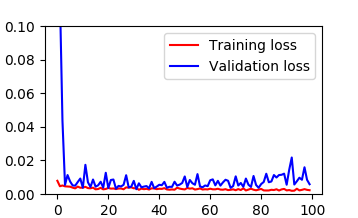

<IPython.core.display.Javascript object>


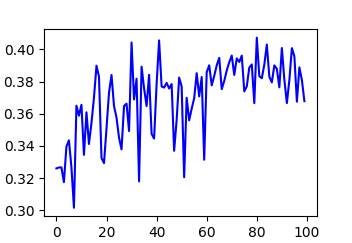

In [51]:
# Show training history
mean_val_IOUs = [np.mean(iou) for iou in val_IOUs]
print("Minimum validation loss: ", np.min(val_losses), " at epoch ", np.argmin(val_losses))
print("Maximum validation IOU: ", np.max(mean_val_IOUs), " at epoch ", np.argmax(mean_val_IOUs))
print("Last validation loss: ", val_losses[-1])
print("Last validation IOU: ", mean_val_IOUs[-1])

# Loss Curves
plt.figure()
x = np.arange(len(train_losses))
plt.plot(x, train_losses,'r-')
plt.plot(x, val_losses,'b-')
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.1)
plt.show()

# Validation IOU
plt.figure()
plt.plot(x, mean_val_IOUs,'b-')
plt.xlabel('Epoch')
plt.ylabel('Validatio IOU')
plt.show()

# 7. Model inference

Predict with the trained model on the test set and calculate IOUs. 

#### Important: 
If sections 4.1 and 5 have not been executed, execute them before proceeding. <br>
Iff section 6.4 has not been executed, run the following cell. 

In [ ]:
unet = UNetwork(drop = DROPOUT, base_filt = BASE_FILT, should_pad = True)

In [52]:
TEST_MODEL_NAME = 'm10a1d-95'
SAVE_PATH = "./tf/" 
BATCH_SIZE = 10 # was 3 originally

# Load the test set
test = pickle.load(file = open('./pickles/heq_test.pkl', 'rb'))

config = tf.ConfigProto()
test_predictions = []
with tf.Session(config=config) as sess:
    print('Loading saved model ...')
    restorer = tf.train.import_meta_graph(SAVE_PATH + TEST_MODEL_NAME + '.meta')
    restorer.restore(sess, SAVE_PATH + TEST_MODEL_NAME)
    print("Model sucessfully restored")
    pred_out = [] # Predictions for each test scan
    x_orig = []   # list of non-scaled scans
    y_orig = []   # list of non-scaled annotations
    x_in = []
    y_in = []
    i = 0
    iou_out = []  # IOUs for each test scan

    while i < len(test): # Iterate over batches
        x_batch = []
        y_batch = []
        for j in range(i, min(len(test), i + BATCH_SIZE)): # Iterate over samples within the batch
            x_orig.append(np.copy(test[j][0]))
            y_orig.append(np.copy(test[j][1]))
            x_cur, y_cur = get_scaled_input(test[j])
            x_batch.append(x_cur)
            y_batch.append(y_cur)
        if len(x_batch) == 0: break
        print('Processing ', i)
        x_in = x_in + x_batch
        y_in = y_in + y_batch
        test_dict = {
            unet.training: False, # Whether to perform batch-norm at inference (Paper says this would be useful)
            unet.model_input: x_batch,
            unet.model_labels: y_batch
        }
        test_predictions = np.squeeze(sess.run([unet.predictions], feed_dict = test_dict))
        if len(x_batch) == 1:
            pred_out.append(test_predictions)
        else:
            pred_out.extend([np.squeeze(test_predictions[z, :, :, :]) for z in list(range(len(x_batch)))])
        i += BATCH_SIZE

    for i in range(len(y_orig)):
        iou = get_mean_iou(pred_out[i], y_orig[i], ret_full = True)
        print('Test scan', i,': IOUs: ', iou, 'Mean: ', np.mean(iou))
        iou_out.append(np.mean(iou))
    print('Mean test IOU', np.mean(iou_out), 'Std IOU', np.std(iou_out)) # mean over all test scans
    
# Save test predictions
pickle.dump(file = open('./pickles/pred_' + TEST_MODEL_NAME + '.pkl', 'wb'), obj = pred_out)

Loading saved model ...
INFO:tensorflow:Restoring parameters from ./tf/m10a1d-95

Test scan 0 : IOUs:  [0.9777711537671306, 0.11682447947573467, 0.22131545849531215] Mean:  0.43863703057939246
Test scan 1 : IOUs:  [0.9745193174849393, 0.13978469238396524, 0.19584966025330575] Mean:  0.43671789004073674
Test scan 2 : IOUs:  [0.9549691765047813, 0.057313632529594837, 0.15163930956835325] Mean:  0.3879740395342431
Test scan 3 : IOUs:  [0.9769505916993393, 0.1327324575608446, 0.46310598124882074] Mean:  0.5242630101696683
Test scan 4 : IOUs:  [0.9748857448262348, 0.02469846598227878, 0.13759931868110598] Mean:  0.37906117649653986
Test scan 5 : IOUs:  [0.9637934150669121, 0.025181857081728713, 0.13548286436111162] Mean:  0.3748193788365841
Test scan 6 : IOUs:  [0.9905237963953643, 0.09345606019887127, 0.0] Mean:  0.3613266188647452
Test scan 7 : IOUs:  [0.9703490112490036, 0.09695950006008894, 0.18427844739018218] Mean:  0.41719565289975824
Test scan 8 : IOUs:  [0.9767473456056192, 0.08575

In [53]:
# (Optional) If loading previously saved predictions

TEST_MODEL_NAME = 'm10a1d-95'
pred_out = pickle.load(file = open('./pickles/pred_' + TEST_MODEL_NAME + '.pkl', 'rb'))

x_orig = []   # list of non-scaled scans
y_orig = []
for i in range(len(test)):
    x_orig.append(np.copy(test[i][0]))
    y_orig.append(np.copy(test[i][1]))
    
iou_out = []  # IOUs for each test scan
for i in range(len(y_orig)):
    iou = get_mean_iou(pred_out[i], y_orig[i], ret_full = True)
    print('Test scan', i,': IOUs: ', iou, 'Mean: ', np.mean(iou))
    iou_out.append(np.mean(iou))
print('\nMean test IOU', np.mean(iou_out), 'Std IOU', np.std(iou_out)) # mean over all test scans
print("Best prediction on the test scan: ", np.argmax(iou_out))
print("Worst prediction on the test scan: ", np.argmin(iou_out))

Test scan 0 : IOUs:  [0.9777711537671306, 0.11682447947573467, 0.22131545849531215] Mean:  0.43863703057939246
Test scan 1 : IOUs:  [0.9745193174849393, 0.13978469238396524, 0.19584966025330575] Mean:  0.43671789004073674
Test scan 2 : IOUs:  [0.9549691765047813, 0.057313632529594837, 0.15163930956835325] Mean:  0.3879740395342431
Test scan 3 : IOUs:  [0.9769505916993393, 0.1327324575608446, 0.46310598124882074] Mean:  0.5242630101696683
Test scan 4 : IOUs:  [0.9748857448262348, 0.02469846598227878, 0.13759931868110598] Mean:  0.37906117649653986
Test scan 5 : IOUs:  [0.9637934150669121, 0.025181857081728713, 0.13548286436111162] Mean:  0.3748193788365841
Test scan 6 : IOUs:  [0.9905237963953643, 0.09345606019887127, 0.0] Mean:  0.3613266188647452
Test scan 7 : IOUs:  [0.9703490112490036, 0.09695950006008894, 0.18427844739018218] Mean:  0.41719565289975824
Test scan 8 : IOUs:  [0.9767473456056192, 0.08575477045153977, 0.0684438644731323] Mean:  0.37698199351009704
Test scan 9 : IOUs:  

## 7.1. Visualise predictions

To choose which test scan to show predictions on, pick `img_id` $\in \{0, 1, ... 9\}$. 
The IOUs calculated in the above cell indicate which test scans obtained the best predictions and are therefore the best ones to visualise. 

*Note:* Run section 1.1 if it has not been executed yet.

### 7.1.1 Example: 'best' prediction

We can see that even though the predictions for CG appear earlier and predictions for PZ disappear slightly later than they should, the predictions in the middle match the annotations very well. In general, the sample predictions indicate that the model rather overestimates the size of the prostate. 

**Press 'j' or 'k' to cycle through the plots in depth (Jupyter must be run locally!).**

<IPython.core.display.Javascript object>


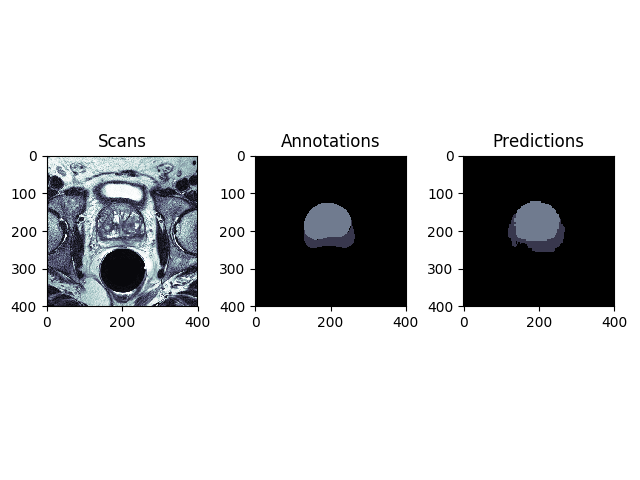

In [54]:
img_id = 3
x_cur = x_orig[img_id]
y_cur = y_orig[img_id]
y_upscale = upscale_segmentation(swap_axes(pred_out[img_id][:, :, :, np.newaxis]), np.shape(x_cur))
multi_slice_viewer(x_cur, y_cur, y_upscale) # View  images, labels and predictions together 

### 7.1.2. Example: 'worst' prediction

We can see that there are almost no CG region predictions and the PZ is predicted at wrong positions. This may be caused by insufficient variability of the training data. 

**Press 'j' or 'k' to cycle through the plots in depth (Jupyter must be run locally!).**

<IPython.core.display.Javascript object>


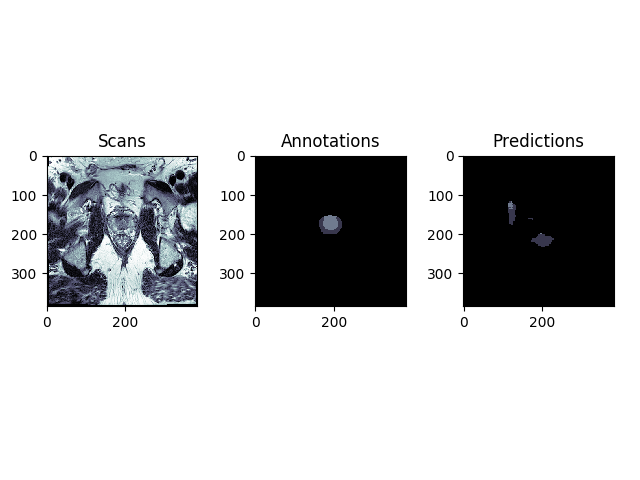

In [58]:
img_id = 6
x_cur = x_orig[img_id]
y_cur = y_orig[img_id]
y_upscale = upscale_segmentation(swap_axes(pred_out[img_id][:, :, :, np.newaxis]), np.shape(x_cur))
multi_slice_viewer(x_cur, y_cur, y_upscale) # View  images, labels and predictions together 